In [1]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body, get_moon

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime, timedelta
from time import mktime
# import 3d -> 2d function
from ipynb.fs.full.convert2d import convert2d, Rotate_z, Rotate_y
from ipynb.fs.full.Helpers import convert_cartesian,convert_ephemeri,generate_ephemeri


In [4]:
# from google.colab import  drive
# drive.mount('/drive')

In [5]:
# !ls '/drive/My Drive/PROJ S'

In [6]:
# merc = pd.read_csv("/drive/My Drive/PROJ S/Train_Test_data/Mercury2x.csv")
# jup =  pd.read_csv("/drive/My Drive/PROJ S/Train_Test_data/Jupiter2x.csv")

# jup =  pd.read_csv("Jupiter2x.csv")

In [7]:
def scale(X,upper = 1, lower = 0):
    ## TODO: vectorize, taking too long
    n = len(X)
    X_std = (np.array([((X[i] - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))) for i in range(0,n)]))*(upper-lower)
    X_std = X_std + lower
    return X_std

def scale1d(X,upper = 1, lower = 0):
    ## TODO: vectorize, taking too long
    n = len(X)
    X_std = (np.array([((X[i] - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))) for i in range(0,n)]))*(upper-lower)
    X_std = X_std + lower
    return X_std

def epi_x(t, a, b, R):
  return (a + b)*np.cos(t) - R*np.cos(t*(a+b/b))

def epi_y(t, a, b, R):
  return (a + b)*np.sin(t) - R*np.sin(t*(a+b/b))

def plot_epic(t, a, b, R, cycles):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    
    # Prepare arrays x, y, z
    theta = np.linspace(0, cycles*2* np.pi, len(t))

    x_small = scale(epi_x(theta, a, b, R), upper=1, lower=-1)
    y_small = scale(epi_y(theta, a, b, R), upper=1, lower=-1)

    ax.scatter(0,0, c='orange', label='Geometric Center')
    ax.scatter(0, np.max(y_small)/3, c='green', label='Earth')
    ax.plot(x_small, y_small, label='Epicycloid function')
    ax.view_init(azim=-90, elev=90)
    ax.set_aspect('equal', adjustable="box")
    ax.legend()

    plt.show()

def grad_loss(t, x, y, a, b, R, func='MSE'):
  """ computes gradient of loss function w.r.t. all training samples (batch GD)
  for the current iterations of the three weights a, b, R
  MSE: 1/2*(epi(t_i, w) - y_i)**2
  """
  n = t.shape[0]
  # grad_x = np.zeros((n, 3))
  # grad_y = np.zeros((n, 3))
  grad = np.zeros(3)
  loss = 0

  if func == 'MSE':
    epic_x = epi_x(t, R, a, b) - x 
    epic_y = epi_y(t, R, a, b) - y 
    
    dydR = (epic_y)*(-np.sin((a+b)*(t/b)))
    dydb = (epic_y)*((a*R*t*np.cos(t*(a+b)/b)/(b**2)) + np.sin(t))
    dyda= (epic_y)*(np.sin(t) - R*t*np.cos(t*(a+b)/b)/b)

    dxdR = (epic_x)*(-np.cos((a+b)*(t/b)))
    dxdb = (epic_x)*(-(a*R*t*np.sin(t*(a+b)/b)/(b**2)) + np.cos(t))
    dxda = (epic_x)*(np.cos(t) + R*t*np.sin(t*(a+b)/b)/b)


    dlda = (1/n) * np.sum((1/2)*np.sqrt((epic_x)**2 + (epic_y)**2)*(2*(dxda + dyda)))
    dldb = (1/n) * np.sum((1/2)*np.sqrt((epic_x)**2 + (epic_y)**2)*(2*(dxdb + dydb)))
    dldR = (1/n) * np.sum((1/2)*np.sqrt((epic_x)**2 + (epic_y)**2)*(2*(dxdR + dydR)))
    

    # grad_y = np.array((dyda, dydb, dydR))

    

    grad = np.array((dlda, dldb, dldR))

    loss = (1/n)* np.sum(np.sqrt((epic_x)**2 + (epic_y)**2))
    # print(loss)
    # loss_x = 1/2*np.mean((epi_x(t, R, a, b) - x)**2)
    # loss_y = 1/2*np.mean((epi_y(t, R, a, b) - y)**2)
  return grad, loss

def grad_descent(t, x, y, a, b, R, lr = 0.001, iters = 1000, epsilon=0.001, num_cycles=2):

#   t_norm = scale(t, upper = 2*np.pi*num_cycles,lower = 0)
#   x_norm = np.array(x.apply(lambda v: (v - min(x))/(max(x) - min(x))))
#   y_norm = np.array(y.apply(lambda e: (e - min(y))/(max(y) - min(y))))
  # print(x_norm)
  # y_norm = 
  # x_cost = np.zeros(iters)
  # y_cost = np.zeros(iters)
  cost = np.zeros(iters)


  for iter in range(iters):

    grad, loss = grad_loss(t, x, y, a, b, R)
    # x_cost[iter] = l_x
    # y_cost[iter] = l_y

    if iter >= 1000000:
      if ((loss - cost[iter -1]) > 0) or (np.abs(loss - cost[iter -1]) < epsilon):
        cost[iter] = loss
        print(cost[:100])

        fig,ax = plt.subplots(figsize=(12,8))
      
        ax.set_ylabel('MSE Loss')
        ax.set_xlabel('Iterations')
        _=ax.plot(range(iters),cost,'b.')
        return np.array((a, b, R)) 
    cost[iter] = loss


    a = a - lr*grad[0]
#     b = b - lr*grad[1]
#     R = R - lr*grad[2]

  print(cost[:100])

  fig,ax = plt.subplots(figsize=(12,8))
 
  ax.set_ylabel('MSE Loss')
  ax.set_xlabel('Iterations')
  _=ax.plot(range(iters),cost,'b.')
  return np.array((a, b, R)) 



# grad_loss(8, 16, 2, np.arange(0, 10500), merc['X'], merc['Y'])
# x = merc['X']
# c = x.apply(lambda v: (v - min(x))/(max(x) - min(x)))
# c.hist()

# np.arange(0, 10500).shape[0]

In [8]:
def grad_loss2(t, x, y, theta, offset=15,func='MSE'):
  """ computes gradient of loss function w.r.t. all training samples (batch GD)
  for the current iterations of the rotation parameter theta
  MSE: 1/N ...
  """
  n = t.shape[0]

  grad = 0
  loss = 0
  mse = 0

  if func == 'MSE':
#     offset = 15
    x1 = x[offset:n//2]
    y1 = y[offset:n//2]
    x2 = x[n//2:-offset]
    y2 = y[n//2:-offset]
#     print(x2)
   
    R = np.array([[np.cos(theta), np.sin(theta)],
                  [-np.sin(theta), np.cos(theta)]])

    carts = np.vstack((x1, y1))
    carts2 =  np.vstack((x2, y2))
#     print(R.shape, carts.shape)
    rot = R @ carts
#     print(x1.shape, x2.shape, y1.shape, y2.shape)
    dldt = (1/n)*np.sum(x1**2 + y1**2 + x2**2 + y2**2 + 2*(x1*x2 + y1*y2)*np.sin(theta) 
                        + 2*(x1*y2 - y1*x2)*np.cos(theta))

    grad = dldt

#     norm_loss = (1/n)* np.sum(np.sqrt((rot[0,:] - x_test)**2 + (rot[1, :] - y_test)**2))
    two_norm = (1/n) * np.sum(np.linalg.norm((rot - carts2), axis=0)**2)
#     print(two_norm.shape)
#     mse =  (1/n)* np.sum((rot[0,:] - x_test)**2 + (rot[1, :] - y_test)**2)
    
    loss = two_norm
    
  return grad, loss

def grad_descent2(t, x, y, theta, lr = 0.001, iters = 1000, offset=15, epsilon=0.0001, num_cycles=2):

  losses = np.zeros(iters)
  thetas = np.zeros(iters)
  for iter in range(iters):

    grad, loss = grad_loss2(t, x, y, theta, offset)

    if iter >= 1000000:
      if ((loss - cost[iter -1]) > 1000000*epsilon) or (np.abs(loss - cost[iter -1]) < epsilon):
        cost[iter] = loss
        print(cost[:100])
        fig,ax = plt.subplots(figsize=(12,8))      
        ax.set_ylabel('MSE Loss')
        ax.set_xlabel('Iterations')
        _=ax.plot(range(iters),cost,'b.')
        return theta
    losses[iter] = loss
    thetas[iter]= theta

    theta = theta - lr*grad
#   print(losses[:100])

  fig,ax = plt.subplots(figsize=(12,8))
  ax.set_ylabel('MSE Loss')
  ax.set_xlabel('Iterations')
  _=ax.plot(range(iters),losses,'b.')
  return thetas, losses

## Preprocessing

In [9]:
def scale_test(x, train):
    """ 
    scales test point to [-1, 1] based on train distirbution
    """
    return 2*(x - np.min(train))/(np.max(train) - np.min(train)) - 1

In [10]:
# t_norm = scale(np.arange(0, 105), upper = 2*np.pi*2,lower = 0)
# mars = convert2d(file='Mars2x.csv')
jup, rotheta, phi = convert2d(file='Jupiter4x.csv')
idx = len(jup)
jup_test = jup[idx//2:]
jup_train = jup[:idx//2]

y_scl = scale(jup_train["Y"], upper = 1.0, lower=-1.0)
x_scl = scale(jup_train["X"], upper = 1.0, lower=-1.0)
y_scl_test = scale(jup_test["Y"], upper = 1.0, lower=-1.0)
x_scl_test = scale(jup_test["X"], upper = 1.0, lower=-1.0)
# y_scl = scale(mars["Y"], upper = 1.0, lower=-1.0)
# x_scl = scale(mars["X"], upper = 1.0, lower=-1.0)
print(jup_train.shape,jup_test.shape)

(5250, 3) (5250, 3)


In [11]:

cycles = 2
train_n = len(x_scl)
t = np.linspace(0, cycles*2*np.pi,train_n)


In [47]:
class RotisserieRegressor: 
    def __init__(self, planet):
        self.planet = planet
        self.params = {}
        self.n = 0
        self.t = np.zeros(2)
        self.times = np.zeros(2)
        self.x_train = np.zeros(2)
        self.y_train = np.zeros(2)
        self.cycles = 2
        self.rot = 0
        
        if planet == "Jupiter" or planet == "jupiter":
            self.params = {'lr':0.0001, 'iter':3000, 'init_weight':0.1, 'offset':15}
        self.theta = self.params['init_weight']
    def fit(self, times, x, y):
        # x, y scaled in [-1, 1]
        # two cycles used for train
        self.times = times
        self.t = np.linspace(0, self.cycles*2*np.pi,train_n)
        self.x_train = x
        self.y_train = y
        self.n = len(x)
        theta = self.theta
        self.preds = []
        thetas, losses = grad_descent2(t, x, y, theta, self.params['lr'], self.params['iter'], 
                                       offset=self.params['offset'])
#         self.train_loss = np.min(losses)
        theta_hat = thetas[np.argmin(losses)]
        self.theta = theta_hat
        return self 

    def predict(self, t_test):
#         pass
        x1 = self.x_train[:self.n//2]
        y1 = self.y_train[:self.n//2]
        x2 = self.x_train[self.n//2:]
        y2 = self.y_train[self.n//2:]  
#         print(self.times[0])
        start_time = datetime.strptime(self.times[0][:19],'%Y-%m-%d %H:%M:%S')
        test_time = datetime.strptime(t_test,'%Y-%m-%d %H:%M:%S')
        duration = test_time - start_time                        
        time_diff = duration.total_seconds()/(3600*24) 
        cycle_len = (datetime.strptime(self.times[len(x1)][:19],'%Y-%m-%d %H:%M:%S') - 
                        datetime.strptime(self.times[0][:19],'%Y-%m-%d %H:%M:%S')).total_seconds()/(3600*24) 

        cycle_shift = np.floor(time_diff/cycle_len)
#         print(cycle_shift)
        cycle_dec = time_diff/cycle_len - np.floor(time_diff/cycle_len)
        
        thet = self.theta*cycle_shift
        R = np.array([[np.cos(thet), np.sin(thet)],
                      [-np.sin(thet), np.cos(thet)]])

        carts = np.vstack((x1, y1))
        carts2 = np.vstack((x2, y2))
        self.rot = R @ carts
        
        adj = int(self.params['offset'] * cycle_shift)

        pred = rot[:, adj+int(np.ceil(len(x1) * cycle_dec))]
        self.pred = pred
        return pred
    def plot(self, x_test, y_test, flat):
        fig2 = plt.figure(figsize=(20,20))
        ax2 = fig2.add_subplot(121)
        x1 = self.x_train[:self.n//2]
        y1 = self.y_train[:self.n//2]
        print(flat.shape)
        ax2.plot(x1, y1, label='train')
        ax2.plot(rot[0, :], rot[1, :], c = 'orange', label='rotation (pred)')
        ax2.plot(flat[:,0], flat[:, 1], label='test')
        ax2.scatter(x_test, y_test, c='black', label='test point')
        ax2.scatter(self.pred[0], self.pred[1], c='green', label='predicted point')
        ax2.set_aspect('equal', adjustable="box")
        plt.legend()
        plt.show()
        
        
        
        
                

(3,)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

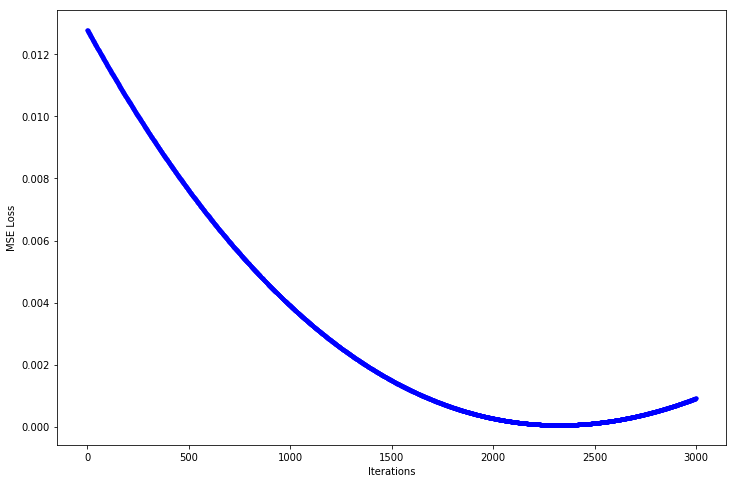

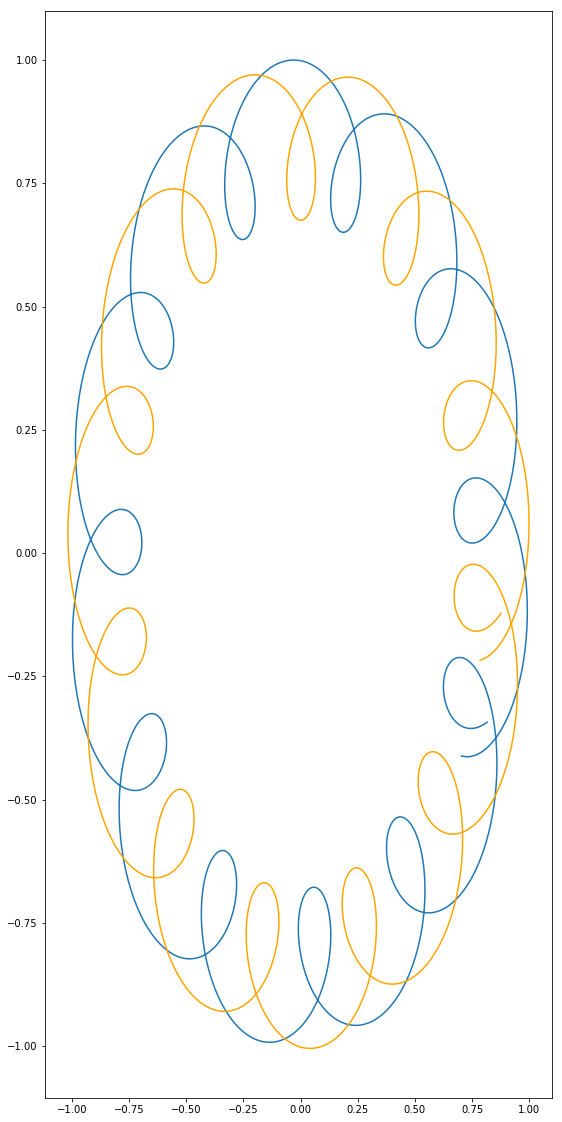

In [48]:
model = RotisserieRegressor('Jupiter')
model = model.fit(jup_train.index, x_scl, y_scl)

test_pnt = '2019-10-01 18:00:00'
ciii = pd.date_range('2014-10-01 18:00:00', '2020-01-01 18:00:00', periods=1000)
preds = model.predict(test_pnt)
test_row=generate_ephemeri('Jupiter', [test_pnt], 'multiple mirror telescope')

test_row2=generate_ephemeri('Jupiter', ciii, 'multiple mirror telescope')


flat = Rotate_z(np.array((test_row['X'][0], test_row['Y'][0], test_row['Z'][0])), -rotheta)
flat = Rotate_y(flat, -phi)

flat2 = Rotate_z(test_row2[['X', 'Y', 'Z']].to_numpy(), -rotheta)
flat2 = Rotate_y(flat, -phi)
x_test=scale_test(flat[0], jup_train['X'])
y_test=scale_test(flat[1], jup_train['Y'])
model.plot(x_test, y_test, flat2)

print("theta =", model.theta)
print("pred = ", preds)
print("actual =", x_test, y_test)


37185319.51001332
[7.04120716e-01 7.08744428e-01 7.13421074e-01 ... 8.11058228e-01
 8.16185303e-01 3.71853195e+07]


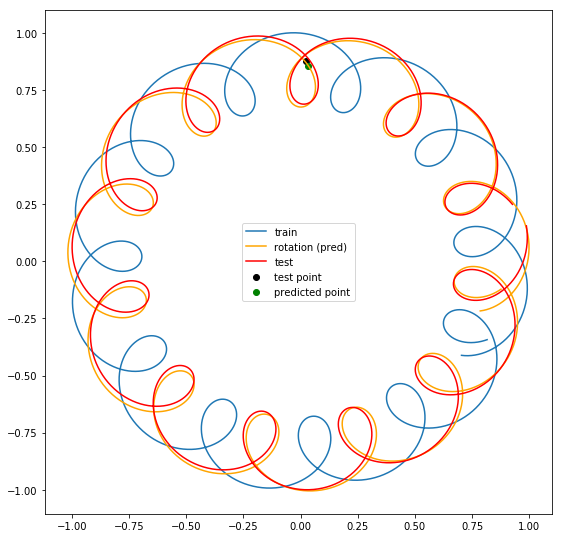

In [25]:

x1 = x_scl[:train_n//2]
y1 = y_scl[:train_n//2]
x2 = x_scl[train_n//2:]
y2 = y_scl[train_n//2:]

x3 = x_scl_test[train_n//2:]
y3 = y_scl_test[train_n//2:]

start_time = datetime.strptime(jup_train.index[0][:19],'%Y-%m-%d %H:%M:%S')
# then = datetime.strptime('2020-11-26','%Y-%m-%d')
test_ind = 3300

test_time = datetime.strptime(jup_test.index[test_ind][:19],'%Y-%m-%d %H:%M:%S')
                        # N
duration = test_time - start_time                         # For build-in functions
time_diff = duration.total_seconds()/(3600*24) 
# print(duration_in_d)

cycle_len = (datetime.strptime(jup_train.index[len(x1)][:10],'%Y-%m-%d') - 
                        datetime.strptime(jup_train.index[0][:10],'%Y-%m-%d')).total_seconds()/(3600*24) 
# t_test = 2*np.pi*(time_diff/cycle_len)
cycle_shift = np.floor(time_diff/cycle_len)
cycle_dec = time_diff/cycle_len - np.floor(time_diff/cycle_len)

print(np.array(jup_test.iloc[test_ind,:]['X']))
tempx = x1.copy()
tempx = np.append(tempx,jup_test.iloc[test_ind,:]['X'])
tempy = y1.copy()
tempy = np.append(tempy,jup_test.iloc[test_ind,:]['Y'])


print(tempx)
# x_test_point = x3[test_ind - train_n//2]
x_test_point = scale_test(jup_test.iloc[test_ind,:]['X'], jup_train['X'])
# print("test", x_test_point, y_test_point)
# scale(tempx, upper=1, lower=-1)[-1]
y_test_point = scale_test(jup_test.iloc[test_ind,:]['Y'], jup_train['Y'])
# y3[test_ind - train_n//2]


# print(x1.shape, x2.shape)
thet = model.theta*cycle_shift
R = np.array([[np.cos(thet), np.sin(thet)],
              [-np.sin(thet), np.cos(thet)]])

carts = np.vstack((x1, y1))
carts2 = np.vstack((x2, y2))
rot = R @ carts

offset = 15
adj = int(offset * cycle_shift)

pred = rot[:, adj+int(np.ceil(len(x1) * cycle_dec))]

two_norm = (1/train_n) * np.sum(np.linalg.norm((rot - carts2), axis=0))

# print(two_norm)
# print((rot - carts2).shape)
fig2 = plt.figure(figsize=(20,20))
ax2 = fig2.add_subplot(121)


ax2.plot(x1, y1, label='train')
ax2.plot(rot[0, :], rot[1, :], c = 'orange', label='rotation (pred)')
# ax2.plot(x2,y2,c='r',label='test')
# ax2.scatter(x1[350], y1[350], c='black', label='1st')
# ax2.scatter(x2[350], y2[350], c='green', label='2nd')

# rotated train
# ax2.plot(rot[0, :][:-35], rot[1, :][:-35], c = 'orange', label='rotation')

# test
ax2.plot(x3[adj:], y3[adj:],c='r',label='test')
ax2.scatter(x_test_point, y_test_point, c='black', label='test point')
ax2.scatter(pred[0], pred[1], c='green', label='predicted point')
# ax2.scatter(x2[1515], y2[1515], c='green')
# print(pred[0], pred[1])
ax2.set_aspect('equal', adjustable="box")
plt.legend()
plt.show()

# predict()



(2, 5250)
0.021305824255326355
0.021305824255326355


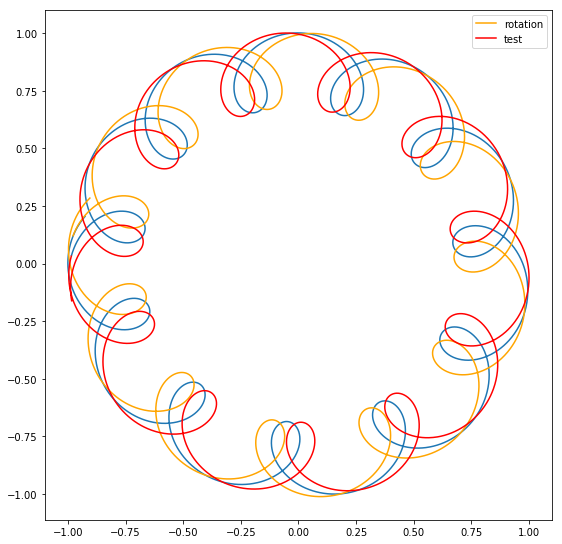

In [402]:
# clockwise 2D rotation matrix


fig2= plt.figure(figsize=(20,20))
ax2 = fig2.add_subplot(121)

R = 2.2
a = 11
b = 1
# ax2 = fig2.gca(projection='3d')

# plt.plot(rot[0, :], rot[1,:], c='r')
# epic_x = epi_x(t, R, a, b) - x_scl 
# epic_y = epi_y(t, R, a, b) - y_scl 
# loss = (1/n)* np.sum(np.sqrt((epic_x)**2 + (epic_y)**2))

x_train = x_scl[:n//2]
y_train = y_scl[:n//2]
x_test = x_scl[n//2:]
y_test = y_scl[n//2:]

w = 5 * (np.pi/180)
R = np.array([[np.cos(w), np.sin(w)],
              [-np.sin(w), np.cos(w)]])

carts = np.vstack((x_train, y_train))
carts2 = np.vstack((x_test, y_test))
rot = R @ carts
print((rot - carts2).shape)

loss = (1/n)* np.sum((rot[0,:] - x_test)**2 + (rot[1, :] - y_test)**2)
two_norm = (1/n) * np.sum(np.linalg.norm((rot - carts2), axis=0)**2)
print(loss)
print(two_norm)
# print(rot.shape)
# train
ax2.plot(x_train, y_train)

# rotated train
ax2.plot(rot[0, :], rot[1, :], c = 'orange', label='rotation')

# test
ax2.plot(x_test, y_test, c='r',label='test')

# theta = np.linspace(0, cycles*2* np.pi, len(t))

# x_small = scale(epi_x(theta, a, b, R), upper=1, lower=-1)
# y_small = scale(epi_y(theta, a, b, R), upper=1, lower=-1)

# ax2.plot(x_small, y_small, label='Epicycloid function', c='r')
ax2.set_aspect('equal', adjustable="box")
plt.legend()
plt.show()
# plot_epic(t, 11.1, 1,3,1)


In [284]:
# n = len(jup['X'])

# # cycle_diffx = (jup['X'].to_numpy())[:n//2]- (jup['X'].to_numpy())[n//2:]
# cycle_diffx = x_scl[:n//2] - x_scl[n//2:]
# plt.hist(cycle_diffx, bins=100)

# - (jup['X'].to_numpy)[n//2:]
# jup['X'].to_numpy().shape
# # cycle_diffy = jup['Y'][:n//2]  - jup['Y'][n//2:]
# cycle_diffx


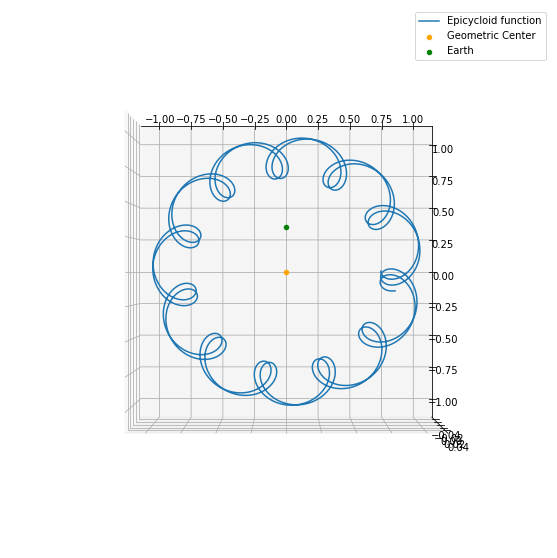

In [216]:
plot_epic(t, 11.1, 1, 2.2, 2)

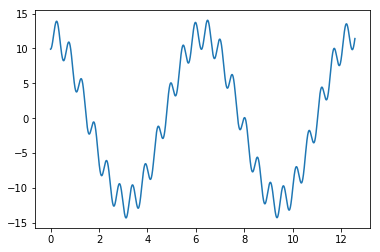

In [197]:
# plt.plot(np.arange(0, 10500, 1), jup['X'], c='orange')
plt.plot(np.linspace(0, 4*np.pi, 10500), epi_x(t, 11.1, 1, 2.2))
plt.show()

## Jupiter can be represented roughly by Epicycloid(a = 11.1, b = 1, R = 2.2)


## Saturn = Epicycloid(a = 28, b = 1, R = 3)

### In general, for outer planets, a/b = number of inner loops

In [198]:
plot_epic(np.arange(0, 2*np.pi, 0.02), 11, 1.4, 3)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.set_aspect('equal', adjustable='box')
# plt.plot(,y)
# plt.xlim(-3,3)
# plt.ylim(-3,3)



fig2= plt.figure(figsize=(20,20))
ax2 = fig2.add_subplot(121)
# ax2 = fig2.gca(projection='3d')
plt.plot(x_scl, y_scl)

ax2.set_aspect('equal', adjustable="box")

#   # fig = plt.figure()
#   # ax = fig.add_subplot(111)
#   # plt.scatter(epi_x(t, R, a, b), epi_y(t, R, a, b))
#   # ax.set_aspect('equal', adjustable='box')


# fig1= plt.figure()
# ax1 = fig1.gca(projection='3d')
# ax1.plot(merc['X'], merc['Y'], np.zeros_like(merc['Y']))
# # plt.title("Real Orbit")

TypeError: plot_epic() missing 1 required positional argument: 'cycles'